In [8]:
import pandas as pd
import numpy as np
import cvxpy as cp
import scipy
from scipy import optimize
# import nltk
import tqdm
import matplotlib.pyplot as plt
import warnings
import tqdm

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator

import torch

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

## Kernel

In [9]:
import numpy as np
from pykeops.torch import LazyTensor
from pykeops.numpy import LazyTensor as LazyTensor_np

class RBF_torch:
    def __init__(self, sigma=1.):
        self.sigma = sigma  # the variance of the kernel

    def kernel(self, X, Y):
        # Input vectors X and Y of shape Nxd and Mxd
        X = torch.tensor(X).type(tensor)
        Y = torch.tensor(Y).type(tensor)
        X = LazyTensor(X[:, None, :])
        Y = LazyTensor(Y[None, :, :])  # (1, M, d)

        # Compute the squared distance matrix
        D_ij = ((X - Y) ** 2).sum(axis=2)  # (N, M)

        # Compute the RBF kernel
        K_ij = (-D_ij / (2 * self.sigma ** 2)).exp()

        return K_ij

    def __str__(self):
        return f'RBF {self.sigma}'

class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  # the variance of the kernel

    def kernel(self, X, Y):
        # Input vectors X and Y of shape Nxd and Mxd
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        X = LazyTensor_np(X[:, None, :])
        Y = LazyTensor_np(Y[None, :, :])  # (1, M, d)

        # Compute the squared distance matrix
        D_ij = ((X - Y) ** 2).sum(axis=2)  # (N, M)

        # Compute the RBF kernel
        K_ij = (-D_ij / (2 * self.sigma ** 2)).exp()

        return K_ij

    def __str__(self):
        return f'RBF {self.sigma}'


class RBF_native:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.exp(-np.sum((X[:,None]-Y[None])**2, axis=-1)/2/self.sigma**2)
    def __str__(self):
        return f'RBF {self.sigma}'

class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return np.dot(X,Y.T)
    def __str__(self):
        return 'Linear'

class Jaccard:
    def __init__(self, renorm=False):
        self.renorm = renorm
    def kernel(self,X,Y):
        if self.renorm:
            X[X>0] = 1
            Y[Y>0] = 1
        ## Input vectors X and Y of shape Nxd and Mxd
        return 2*np.dot(X,Y.T)/(np.linalg.norm(X,axis=-1)[:,None]+np.linalg.norm(Y,axis=-1)[None])
    def __str__(self):
        return f'Jaccard renorm={self.renorm}'

In [10]:
## Local alignment kernel

import multiprocessing as mp
# from tqdm import tqdm

def local_alignment_kernel(x, y, beta, d, e):
    # Lengths of sequences
    len_x = len(x)
    len_y = len(y)

    # Initialize matrices
    M = np.zeros((len_x + 1, len_y + 1))
    X = np.zeros((len_x + 1, len_y + 1))
    Y = np.zeros((len_x + 1, len_y + 1))
    X2 = np.zeros((len_x + 1, len_y + 1))
    Y2 = np.zeros((len_x + 1, len_y + 1))

    # Define the similarity function S(xi, yj)
    def S(xi, yj):
        return 1 if xi == yj else -1

    # Fill the matrices using the recursive relations
    for i in range(1, len_x + 1):
        for j in range(1, len_y + 1):
            M[i, j] = np.exp(beta * S(x[i - 1], y[j - 1])) * (1 + X[i - 1, j - 1] + Y[i - 1, j - 1] + M[i - 1, j - 1])
            X[i, j] = np.exp(beta * d) * M[i - 1, j] + np.exp(beta * e) * X[i - 1, j]
            Y[i, j] = np.exp(beta * d) * (M[i, j - 1] + X[i, j - 1]) + np.exp(beta * e) * Y[i, j - 1]
            X2[i, j] = M[i - 1, j] + X2[i - 1, j]
            Y2[i, j] = M[i, j - 1] + X2[i, j - 1] + Y2[i, j - 1]

    # Compute the LA kernel
    K_LA = 1 + X2[len_x, len_y] + Y2[len_x, len_y] + M[len_x, len_y]

    return K_LA

def compute_kernel(i, X, Y, beta, d, e):
    results = []
    for j in range(Y.shape[0]):
        results.append(local_alignment_kernel(X[i], Y[j], beta, d, e))
    return results

class LA:
    def __init__(self, beta=1, d=-1, e=-1):
        self.beta = beta
        self.d = d
        self.e = e

    def kernel(self, X, Y):
        K = np.zeros((X.shape[0], Y.shape[0]))

        with mp.Pool(mp.cpu_count()) as pool:
            results = list(tqdm.tqdm(pool.starmap(compute_kernel, [(i, X, Y, self.beta, self.d, self.e) for i in range(X.shape[0])]), total=X.shape[0]))

        for i, result in enumerate(results):
            for j, value in enumerate(result):
                K[i, j] = value

        return K

    def __str__(self):
        return f'LA beta={self.beta} d={self.d} e={self.e}'

In [11]:
from collections import Counter, defaultdict
import numpy as np

class MismatchKernel:
    def __init__(self, k):
        self.k = k
        self.mismatch_bases = 'ACGT'

    def generate_kmers(self, seq):
        """Generate all k-mers of a sequence"""
        return [seq[i:i+self.k] for i in range(len(seq) - self.k + 1)]

    def precompute_mismatched_kmers(self, kmer):
        """Precompute all possible mismatched k-mers for a given k-mer"""
        mismatched_kmers = set()
        for i in range(len(kmer)):
            for base in self.mismatch_bases:
                if base != kmer[i]:
                    mismatched_kmer = kmer[:i] + base + kmer[i+1:]
                    mismatched_kmers.add(mismatched_kmer)
        return mismatched_kmers

    def get_mismatch_kmer_counts(self, seq):
        """Calculate the frequencies of k-mers with tolerance to mismatches"""
        kmer_counts = Counter()
        kmers = self.generate_kmers(seq)

        for kmer in kmers:
            kmer_counts[kmer] += 1
            mismatched_kmers = self.precompute_mismatched_kmers(kmer)
            for mismatched_kmer in mismatched_kmers:
                kmer_counts[mismatched_kmer] += 1

        return kmer_counts

    def kernel(self, X1, X2):
        """Calculate the mismatch kernel matrix between two sets"""
        n1, n2 = len(X1), len(X2)
        K = np.zeros((n1, n2))

        # Build the set of k-mers for each sequence
        kmer_features_1 = [self.get_mismatch_kmer_counts(seq) for seq in X1]
        kmer_features_2 = [self.get_mismatch_kmer_counts(seq) for seq in X2]

        # Calculate the kernel based on k-mers
        for i in range(n1):
            for j in range(n2):
                common_kmers = set(kmer_features_1[i].keys()) & set(kmer_features_2[j].keys())
                for kmer in common_kmers:
                    K[i, j] += kmer_features_1[i][kmer] * kmer_features_2[j][kmer]

        return K

    def __str__(self):
        return f'MismatchKernel(k={self.k})'


## SVM

In [12]:
class KernelSVCKeops(BaseEstimator):
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None # support vectors
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)

        self.K = self.kernel(X,X)
        # yKy = np.outer(y,y)*self.K
        # Lagrange dual problem
        def loss(alpha):
            alpha_y = alpha*y
            Kalpha_y = self.K @ alpha_y
            return 1/2* alpha_y.dot(Kalpha_y) - np.sum(alpha)
            # return 1/2* alpha.dot(yKy).dot(alpha) - np.sum(alpha)

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            alpha_y = alpha*y
            Kalpha_y = self.K @ alpha_y
            return y * Kalpha_y - np.ones(N)
            # return np.dot(yKy, alpha) - np.ones(N)


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: np.dot(alpha, y) 
        jac_eq = lambda alpha:   y
        # 0 <= alpha <= C
        fun_ineq = lambda alpha: np.concatenate((alpha, self.C - alpha))
        jac_ineq = lambda alpha: np.concatenate((np.eye(N), -np.eye(N)))
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        # alpha_init = np.random.rand(N)*self.C
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.zeros(N),
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x
        ## Assign the required attributes
        conditions = (self.alpha > self.epsilon)
        self.parameters = self.alpha[conditions]*y[conditions]
        
        self.support = X[conditions]
        support_vector_indices = np.where(conditions)[0]
        Ksupport = self.kernel(self.support, self.support)
        self.b = np.mean(y[support_vector_indices] - Ksupport @ (self.alpha[support_vector_indices] * y[support_vector_indices]))

        self.norm_f = (self.alpha*y).dot(self.K).dot(self.alpha*y)


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        # Kernel
        K = self.kernel(x, self.support)
        return  K.dot(self.parameters)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

In [ ]:
import cvxpy as cp
import numpy as np

class KernelSVC(BaseEstimator):

    def __init__(self, C, kernel, epsilon=1e-3):
        self.type = 'non-linear'
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.support = None  # support vectors
        self.epsilon = epsilon
        self.norm_f = None

    def fit(self, X, y):
        N = len(y)
        self.K = self.kernel(X, X)
        yKy = y[:, None] @ y[None, :] * self.K

        # Define the variable alpha
        alpha = cp.Variable(N)


        # Define the objective function
        objective = cp.Minimize(0.5 * cp.quad_form(alpha, cp.Parameter(shape=yKy.shape, value=yKy, PSD=True)) - cp.sum(alpha))

        # Define the constraints
        constraints = [
            cp.sum(cp.multiply(alpha, y)) == 0,  # Equality constraint
            alpha >= 0,              # Non-negativity constraint
            alpha <= self.C          # Box constraint
        ]

        # Define the problem
        problem = cp.Problem(objective, constraints)

        # Solve the problem
        problem.solve()

        # Extract the solution
        self.alpha = alpha.value

        # Assign the required attributes
        conditions = (self.alpha > self.epsilon)
        self.parameters = self.alpha[conditions] * y[conditions]
        self.support = X[conditions]
        support_vector_indices = np.where(conditions)[0]
        self.b = np.mean(y[support_vector_indices] -
                         np.dot(self.K[support_vector_indices][:, support_vector_indices], self.alpha[support_vector_indices] * y[support_vector_indices]))

        self.norm_f = (self.alpha * y).dot(self.K).dot(self.alpha * y)

    ### Implementation of the separating function $f$
    def separating_function(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        # Kernel
        K = self.kernel(x, self.support)
        return K.dot(self.parameters)

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d + self.b > 0) - 1


In [14]:
class KNNClassifier(BaseEstimator):

    def __init__(self, k, var):
        self.type = 'non-linear'
        self.k = k
        self.var = var

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        kernel = RBF(sigma=self.var).kernel
        K = kernel(X, self.X)
        nn = K.argKmin(self.k, dim=1)
        y_nn = self.y[nn]
        prediction = np.mean(y_nn, axis=1) > 0
        return 2 * prediction.astype(int) - 1

In [15]:
class RidgeRegression(BaseEstimator):
    def __init__(self, alpha, kernel):
        self.alpha = alpha
        self.kernel = kernel

    def fit(self, X, y):
        self.X = X.astype(np.float32)
        K = self.kernel(self.X, self.X)
        # y = y[:, None].astype(np.float32)
        # self.lam = K.solve(y, alpha=self.alpha*K.shape[0])
        self.lam = np.linalg.solve(K + self.alpha * np.eye(K.shape[0])*K.shape[0], y)

    def predict(self, X):
        K = self.kernel(X, self.X)
        return ((K @ self.lam) > 0).astype(int) * 2 - 1

class RidgeRegressionMismatch(BaseEstimator):
    def __init__(self, alpha, kernel):
        self.alpha = alpha
        self.kernel = kernel

    def fit(self, X, y):
        # self.X = X.astype(np.float32)
        self.X = X
        K = self.kernel(self.X, self.X)
        # y = y[:, None].astype(np.float32)
        # self.lam = K.solve(y, alpha=self.alpha*K.shape[0])
        self.lam = np.linalg.solve(K + self.alpha * np.eye(K.shape[0])*K.shape[0], y)

    def predict(self, X):
        K = self.kernel(X, self.X)
        return ((K @ self.lam) > 0).astype(int) * 2 - 1

class RidgeRegressionRBF(BaseEstimator):
    def __init__(self, alpha, var):
        self.alpha = alpha
        self.var = var

    def fit(self, X, y):
        self.kernel = RBF(sigma=self.var).kernel
        self.X = X.astype(np.float32)
        K = self.kernel(self.X, self.X)
        y = y[:, None].astype(np.float32)
        self.lam = K.solve(y, alpha=self.alpha*K.shape[0])

    def predict(self, X):
        K = self.kernel(X, self.X)
        return ((K @ self.lam) > 0).astype(int) * 2 - 1
        

In [16]:
def get_bags_overlapped(df, size_bag, col_name="seq"):
    return df[col_name].apply(lambda x: [x[i:i+size_bag] for i in range(len(x) - size_bag + 1)])

def get_bags(df, size_bag, col_name='seq'):
    return df[col_name].apply(lambda x: [x[i:i+size_bag] for i in range(0, len(x), size_bag)])

def get_all_posibilities(size_bag):
    tokens = ["A", "C", "G", "T"]
    all_subsequence = tokens.copy()
    for i in range(size_bag - 1):
        all_subsequence = [a + b for a in all_subsequence for b in tokens]
    return all_subsequence


In [10]:
df = pd.read_csv('data/Xtr0.csv')
df_y = pd.read_csv('data/Ytr0.csv')

df["Bound"] = df_y["Bound"]
df["y"] = 2*df["Bound"] - 1

In [ ]:
# Quite slow
MismatchKernel(k=5).kernel(df["seq"], df["seq"])

array([[ 5344.,  2664.,  2468., ...,  2816.,  2874.,  3088.],
       [ 2664., 19388.,  2582., ...,  1796.,  1930.,  1946.],
       [ 2468.,  2582.,  4060., ...,  2312.,  2870.,  2790.],
       ...,
       [ 2816.,  1796.,  2312., ...,  3928.,  2654.,  2658.],
       [ 2874.,  1930.,  2870., ...,  2654.,  4592.,  3246.],
       [ 3088.,  1946.,  2790., ...,  2658.,  3246.,  4292.]],
      shape=(1000, 1000))

In [ ]:
# Too slow
LA().kernel(df["seq"].values[:100], df["seq"].values[:100])

100%|██████████| 100/100 [00:00<00:00, 1205259.77it/s]


array([[4.68524886e+48, 4.33171516e+26, 1.15844821e+25, ...,
        1.59321488e+28, 2.29623495e+23, 2.54770566e+34],
       [4.33171516e+26, 2.96517010e+49, 9.98405237e+23, ...,
        2.02324604e+26, 5.10958532e+21, 1.86840255e+27],
       [1.15844821e+25, 9.98405237e+23, 1.31438396e+48, ...,
        1.02927591e+24, 2.29711195e+29, 7.62696599e+25],
       ...,
       [1.59321488e+28, 2.02324604e+26, 1.02927591e+24, ...,
        4.28584946e+48, 1.13314109e+24, 1.48050803e+27],
       [2.29623495e+23, 5.10958532e+21, 2.29711195e+29, ...,
        1.13314109e+24, 2.33669609e+48, 4.86922990e+24],
       [2.54770566e+34, 1.86840255e+27, 7.62696599e+25, ...,
        1.48050803e+27, 4.86922990e+24, 3.92807486e+48]], shape=(100, 100))

In [11]:
size_bag = 5
print(f"Size of the latent representation: {4**size_bag}")
# df['bags'] = df['seq'].apply(lambda x: [x[i:i+size_bag] for i in range(0, len(x), size_bag)])
df['bags'] = get_bags_overlapped(df, size_bag)
all_posibilities = get_all_posibilities(size_bag)
df['counts'] = df['bags'].apply(lambda x: [x.count(subseq) for subseq in all_posibilities])

# Train test split
train_size = 0.8
train_indexes = np.random.choice(df.index, int(train_size*len(df)), replace=False)



train_df = df.loc[train_indexes]
test_df = df.drop(train_indexes)

Size of the latent representation: 1024


## RidgeRegression grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
variance = np.logspace(-2, 2, 5)
parameters_grid = {
    "var":   np.logspace(-1, 4, 5),
    "alpha": np.logspace(-6, -1, 5)
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(RidgeRegressionRBF(3, var=1), parameters_grid, scoring="accuracy", n_jobs=-1)
gridsearch.fit(np.stack(df['counts'].values), np.array(df['y']))

GridSearchCV(estimator=RidgeRessionRBF(alpha=3, var=1), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01]),
                         'var': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'alpha': np.float64(0.00031622776601683794),
  'var': np.float64(31.622776601683793)},
 np.float64(0.6134999999999999))

In [ ]:
variance = np.logspace(-2, 2, 5)
parameters_grid = {
    "kernel": [Linear().kernel, Jaccard(renorm=True).kernel, Jaccard(renorm=False).kernel],
    "alpha": np.logspace(-6, -1, 5)
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(RidgeRegression(3, kernel=Linear().kernel), parameters_grid, scoring="accuracy", n_jobs=5)
gridsearch.fit(np.stack(df['counts'].values), np.array(df['y']))

GridSearchCV(estimator=RidgeRession(alpha=3,
                                    kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f33a564e010>>),
             n_jobs=5,
             param_grid={'alpha': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01]),
                         'kernel': [<bound method Linear.kernel of <__main__.Linear object at 0x7f3417e92910>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f35234bab10>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33a554d350>>]},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'alpha': np.float64(0.1),
  'kernel': <bound method Linear.kernel of <__main__.Linear object at 0x7f3417e92910>>},
 np.float64(0.6165))

In [ ]:
parameters_grid = {
    "kernel": [MismatchKernel(k=3).kernel],
    "alpha": np.logspace(-6, -1, 5)
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(RidgeRegressionMismatch(3, kernel=Linear().kernel), parameters_grid, scoring="accuracy", n_jobs=5)
gridsearch.fit(df["seq"].values, np.array(df['y']))

GridSearchCV(estimator=RidgeRessionMismatch(alpha=3,
                                            kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f33a612a7d0>>),
             n_jobs=5,
             param_grid={'alpha': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01]),
                         'kernel': [<bound method MismatchKernel.kernel of <__main__.MismatchKernel object at 0x7f3420272250>>]},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'alpha': np.float64(0.1),
  'kernel': <bound method MismatchKernel.kernel of <__main__.MismatchKernel object at 0x7f3420272250>>},
 np.float64(0.5860000000000001))

## KNN grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
variance = np.logspace(-2, 2, 5)
parameters_grid = {
    "var":   np.logspace(-2, 2, 5),
    "k": [3, 5, 7]
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(KNNClassifier(3, var=1), parameters_grid, scoring="accuracy", n_jobs=5)
gridsearch.fit(np.stack(df['counts'].values), np.array(df['y']))

/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=KNNClassifier(k=3, var=1), n_jobs=5,
             param_grid={'k': [3, 5, 7],
                         'var': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'k': 5, 'var': np.float64(10.0)}, np.float64(0.5145))

## Grid search RBF

In [ ]:
warnings.filterwarnings("ignore")

## Grid search
kernel = [10, 50, 200]
kernel = [RBF_native(sigma=s) for s in kernel]
C = [0.01,0.1, 1, 10]

results = []
for k in tqdm.tqdm(kernel):
    for c in C:
        model = KernelSVC(C=c, kernel=k.kernel)
        model.fit(np.stack(train_df['counts'].values), np.array(train_df['y']))
        y_pred = model.predict(np.stack(test_df['counts'].values))
        accuracy = accuracy_score(test_df['y'], y_pred)
        results.append((k, c, accuracy))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:24<00:00, 48.18s/it]


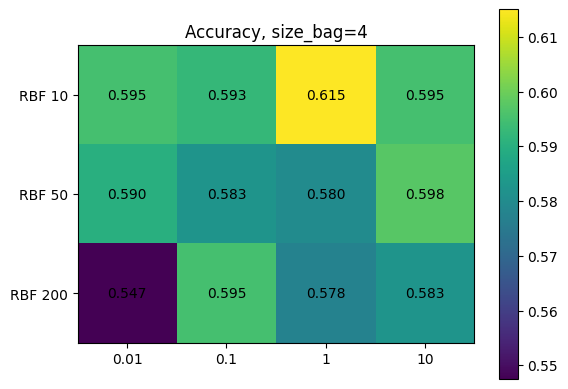

In [ ]:
# heatmap
results = np.array(results)
acc = results[:, 2].astype(float)
acc = acc.reshape(len(kernel), len(C))
plt.imshow(acc, interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(C)), C)
plt.yticks(np.arange(len(kernel)), [str(k) for k in kernel])
# write value on the heatmap
for i in range(len(kernel)):
    for j in range(len(C)):
        plt.text(j, i, f'{acc[i, j]:.3f}', ha='center', va='center', color='black')
plt.title(f"Accuracy, size_bag={size_bag}")
plt.show()

In [ ]:
parameters_grid = {
    "kernel":  [Jaccard().kernel, Jaccard(renorm=True).kernel, Linear().kernel],
    "C": [5e-3, 1e-2, 1e-1, 1, 10]
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(KernelSVC(C=1, kernel=Linear().kernel), parameters_grid, scoring="accuracy", n_jobs=-1)
gridsearch.fit(np.stack(df['counts'].values), np.array(df['y']))

/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_cha

GridSearchCV(estimator=KernelSVC(C=1,
                                 kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f33dec28050>>),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01, 0.1, 1, 10],
                         'kernel': [<bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f341f4dd190>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33a5a2ac50>>,
                                    <bound method Linear.kernel of <__main__.Linear object at 0x7f34201cf7d0>>]},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'C': 0.005,
  'kernel': <bound method Linear.kernel of <__main__.Linear object at 0x7f34201cf7d0>>},
 np.float64(0.618))

## Test with all files

In [ ]:
dfs = [pd.read_csv(f'data/Xtr{i}.csv') for i in range(3)]
dfs_y = [pd.read_csv(f'data/Ytr{i}.csv') for i in range(3)]
df_all = pd.concat(dfs, ignore_index=True)
df_y_all = pd.concat(dfs_y, ignore_index=True)

df_all["Bound"] = df_y_all["Bound"]
df_all["y"] = 2*df_all["Bound"] - 1

In [ ]:
size_bag = 5
print(f"Size of the latent representation: {4**size_bag}")
# df['bags'] = df['seq'].apply(lambda x: [x[i:i+size_bag] for i in range(0, len(x), size_bag)])
df_all['bags'] = get_bags_overlapped(df_all, size_bag)
all_posibilities = get_all_posibilities(size_bag)
df_all['counts'] = df_all['bags'].apply(lambda x: [x.count(subseq) for subseq in all_posibilities])

# Train test split
train_size = 0.2
train_indexes = np.random.choice(df_all.index, int(train_size*len(df_all)), replace=False)


train_df_all = df_all.loc[train_indexes]
test_df_all = df_all.drop(train_indexes)

Size of the latent representation: 1024


In [ ]:
np.stack(train_df_all['counts'].values).shape

(1800, 256)

In [ ]:
# model = KernelSVCKeopsTorch(C=0.1, kernel=RBF_torch().kernel)
# model.fit(np.stack(train_df_all['counts'].values), np.array(train_df_all['y']))

In [ ]:
model = KernelSVCKeops(C=0.1, kernel=RBF().kernel)
model.fit(np.stack(train_df_all['counts'].values), np.array(train_df_all['y']))

In [ ]:
model = KernelSVCKeops(C=0.1, kernel=RBF_native().kernel)
model.fit(np.stack(train_df_all['counts'].values), np.array(train_df_all['y']))

In [ ]:
model = KernelSVC(C=0.1, kernel=Jaccard().kernel)
model.fit(np.stack(train_df_all['counts'].values), np.array(train_df_all['y']))

/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [ ]:
y_pred = model.predict(np.stack(test_df_all['counts'].values))
accuracy = accuracy_score(test_df_all['y'], y_pred)
print(accuracy)

0.5558333333333333


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
parameters_grid = {
    "kernel":  [Jaccard().kernel, Jaccard(renorm=True).kernel, Linear().kernel],
    "C": [5e-3, 1e-2, 1e-1, 1]
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(KernelSVC(C=1, kernel=Linear().kernel), parameters_grid, scoring="accuracy", n_jobs=-1)
gridsearch.fit(np.stack(df_all['counts'].values), np.array(df_all['y']))

/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_cha

GridSearchCV(estimator=KernelSVC(C=1,
                                 kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f339da12c50>>),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01, 0.1, 1],
                         'kernel': [<bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33bff5f450>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33bff5e590>>,
                                    <bound method Linear.kernel of <__main__.Linear object at 0x7f33bff5f810>>,
                                    <bound method RBF_native.kernel of <__main__.RBF_native object at 0x7f33bff5f850>>]},
             scoring='accuracy')

In [ ]:
gridsearch

GridSearchCV(estimator=KernelSVC(C=1,
                                 kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7ff59ceb5710>>),
             n_jobs=-1,
             param_grid={'C': [0.005, 0.01, 0.1, 1],
                         'kernel': [<bound method Jaccard.kernel of <__main__.Jaccard object at 0x7ff5a0f34f90>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7ff59ceb6690>>,
                                    <bound method Linear.kernel of <__main__.Linear object at 0x7ff59ceb5a90>>]},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_

{'C': 0.1,
 'kernel': <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33bff5f450>>}

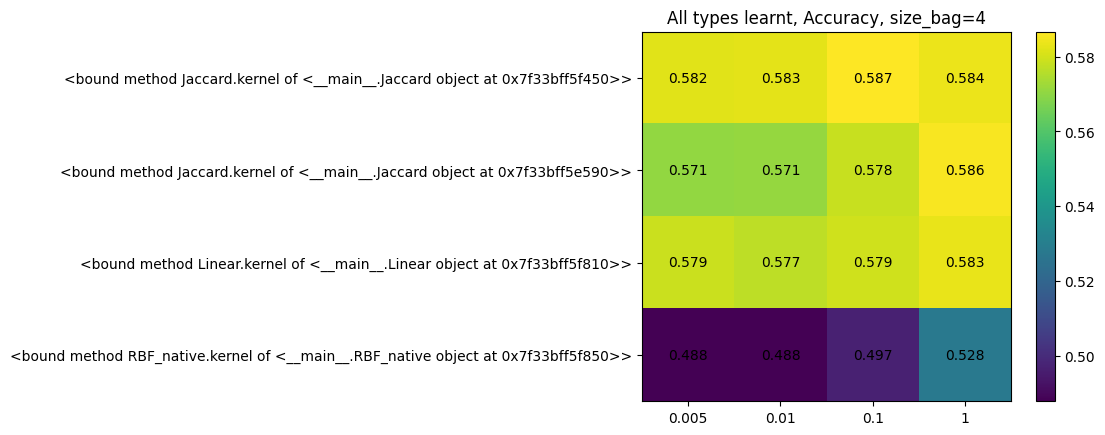

In [ ]:
# heatmap
results = gridsearch.cv_results_["mean_test_score"]
# params_C = gridsearch.cv_results_["param_C"].data
# params_kernel = gridsearch.cv_results_["param_kernel"].data
params_C = parameters_grid["C"]
params_kernel = [str(k) for k in parameters_grid["kernel"]]
results = results.reshape(len(parameters_grid["C"]), len(parameters_grid["kernel"])).T
plt.imshow(results, interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(params_C)), params_C)
plt.yticks(np.arange(len(params_kernel)), params_kernel)
# write value on the heatmap
for i in range(len(params_kernel)):
    for j in range(len(params_C)):
        plt.text(j, i, f'{results[i, j]:.3f}', ha='center', va='center', color='black')
plt.title(f"All types learnt, Accuracy, size_bag={size_bag}")
plt.show()

In [ ]:
size_bag = 5
print(f"Size of the latent representation: {4**size_bag}")
# df['bags'] = df['seq'].apply(lambda x: [x[i:i+size_bag] for i in range(0, len(x), size_bag)])
df_all['bags'] = get_bags_overlapped(df_all, size_bag)
all_posibilities = get_all_posibilities(size_bag)
df_all['counts'] = df_all['bags'].apply(lambda x: [x.count(subseq) for subseq in all_posibilities])

# Train test split
train_size = 0.2
train_indexes = np.random.choice(df_all.index, int(train_size*len(df_all)), replace=False)


train_df_all = df_all.loc[train_indexes]
test_df_all = df_all.drop(train_indexes)

In [ ]:
parameters_grid2 = {
    "kernel":  [Linear().kernel],
    "C": [1, 10]
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch2 = GridSearchCV(KernelSVC(C=1, kernel=Linear().kernel), parameters_grid2, scoring="accuracy", n_jobs=-1)
gridsearch2.fit(np.stack(df_all['counts'].values), np.array(df_all['y']))

/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Data/thomas.loux/micromamba/envs/generative/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_cha

GridSearchCV(estimator=KernelSVC(C=1,
                                 kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f33a4cf7850>>),
             n_jobs=-1,
             param_grid={'C': [1, 10],
                         'kernel': [<bound method Linear.kernel of <__main__.Linear object at 0x7f33a4cf6b90>>]},
             scoring='accuracy')

In [ ]:
variance = np.logspace(-2, 2, 5)
parameters_grid = {
    "kernel": [Linear().kernel, Jaccard(renorm=True).kernel, Jaccard(renorm=False).kernel],
    "alpha": np.logspace(-6, -1, 5)
}
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [ ]:
gridsearch = GridSearchCV(RidgeRegression(3, kernel=Linear().kernel), parameters_grid, scoring="accuracy", n_jobs=-1)
gridsearch.fit(np.stack(df_all['counts'].values), np.array(df_all['y']))

GridSearchCV(estimator=RidgeRession(alpha=3,
                                    kernel=<bound method Linear.kernel of <__main__.Linear object at 0x7f33a5f0cb10>>),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01]),
                         'kernel': [<bound method Linear.kernel of <__main__.Linear object at 0x7f33ba473050>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33ba473250>>,
                                    <bound method Jaccard.kernel of <__main__.Jaccard object at 0x7f33ba471850>>]},
             scoring='accuracy')

In [ ]:
gridsearch.best_params_, gridsearch.best_score_

({'alpha': np.float64(0.1),
  'kernel': <bound method Linear.kernel of <__main__.Linear object at 0x7f33ba473050>>},
 np.float64(0.6085))

In [ ]:
gridsearch.cv_results_["mean_test_score"]

array([0.58816667, 0.58633333, 0.58833333, 0.58983333, 0.59116667,
       0.59416667, 0.596     , 0.59333333, 0.60366667, 0.6025    ,
       0.603     , 0.607     , 0.6085    , 0.59283333, 0.6025    ])

## Submission

In [5]:
import os
from pathlib import Path
data_directory = Path('data/')
nb_tr_to_fit = 3

dfs = [data_directory / f'Xtr{i}.csv' for i in range(nb_tr_to_fit)]
dfs = [pd.read_csv(df) for df in dfs]
df_y = [data_directory / f'Ytr{i}.csv' for i in range(nb_tr_to_fit)]
df_y = [pd.read_csv(df) for df in df_y]

for i in range(nb_tr_to_fit):
    dfs[i]["Bound"] = df_y[i]["Bound"]
    dfs[i]["y"] = 2*dfs[i]["Bound"] - 1

df_test = [data_directory / f'Xte{i}.csv' for i in range(nb_tr_to_fit)]
df_test = [pd.read_csv(df) for df in df_test]

In [17]:
size_bag = 5
print(f"Size of the latent representation: {4**size_bag}")
# df['bags'] = df['seq'].apply(lambda x: [x[i:i+size_bag] for i in range(0, len(x), size_bag)])
for df in dfs:
    df['bags'] = get_bags_overlapped(df, size_bag)
    all_posibilities = get_all_posibilities(size_bag)
    df['counts'] = df['bags'].apply(lambda x: [x.count(subseq) for subseq in all_posibilities])

Size of the latent representation: 1024


In [18]:
for df in df_test:
    df['bags'] = get_bags_overlapped(df, size_bag)
    all_posibilities = get_all_posibilities(size_bag)
    df['counts'] = df['bags'].apply(lambda x: [x.count(subseq) for subseq in all_posibilities])

In [20]:
models = [KernelSVC(C=0.005, kernel=Linear().kernel) for _ in range(nb_tr_to_fit)]
for i in range(nb_tr_to_fit):
    models[i].fit(np.stack(dfs[i]['counts'].values), np.array(dfs[i]['y']))

/opt/homebrew/Caskroom/mambaforge/base/envs/rna/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [ ]:
for i in range(nb_tr_to_fit):
    y_pred = models[i].predict(np.stack(df_test[i]['counts'].values))
    df_test[i]["Bound"] = (y_pred + 1) / 2

# concat
df_test_final = pd.concat(df_test)
df_test_final["Bound"] = df_test_final["Bound"].astype(int)

In [ ]:
df_test_final[["Id", "Bound"]].to_csv("predictions/Yte_svm_mismatchkernel.csv", index=False)